Hand classification using linear regression
===

In [1]:
# Imports
from IPython.display import Video
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time
import queue
import statistics
from tqdm import tqdm 
import pickle   # pip install pickle-mixin
import tensorflow as tf
import keras

## Count fingers
---

In [6]:
def count_finger(grey):
    try:
        # applying gaussian blur
        blurred = cv2.GaussianBlur(grey, (5, 5), cv2.BORDER_DEFAULT)

        contours, hierarchy = cv2.findContours(blurred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cntsMax = max(contours, key=lambda x: cv2.contourArea(x))
        # largeContour = np.vstack([cntsMax[-1], cntsMax[-2]])
        cv2.drawContours(grey, cntsMax, -1, (255, 255, 0))
        gray_bgr = cv2.cvtColor(grey, cv2.COLOR_GRAY2BGR)
        cv2.fillPoly(gray_bgr, pts =[cntsMax], color=(255,255,255))
        grey = cv2.cvtColor(gray_bgr, cv2.COLOR_BGR2GRAY)
        hull1 = cv2.convexHull(cntsMax)
        cv2.drawContours(grey, [hull1], -1, (0, 255, 255), 2)
        areahull = cv2.contourArea(hull1)
        areacnt = cv2.contourArea(cntsMax)
        arearatio = ((areahull - areacnt) / areacnt) * 100
        hull = cv2.convexHull(cntsMax, returnPoints=False)
        defects = cv2.convexityDefects(cntsMax, hull)
        if defects is not None:
            cnt = 0
            for i in range(defects.shape[0]):  # calculate the angle
                s, e, f, d = defects[i][0]
                start = tuple(cntsMax[s][0])
                end = tuple(cntsMax[e][0])
                far = tuple(cntsMax[f][0])
                a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
                b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
                c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
                angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))  # cosine theorem
                if angle <= np.pi / 2:  # angle less than 90 degree, treat as fingers
                    cnt += 1
                    cv2.circle(grey, far, 4, [0, 0, 255], -1)
            if cnt > 0:
                cnt = cnt + 1
            if cnt == 0 and arearatio >= 12:
                cnt = cnt + 1
            cv2.putText(grey, str(cnt), (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    except:
        return grey
    return grey


## Preview video with frames
---

In [18]:
def preview_video(input_video_path: str, output_video_path: str):
    cap = cv2.VideoCapture(input_video_path)
    out = cv2.VideoWriter(output_video_path, -1, 20.0, (640,480))
    # get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    suc, prev = cap.read()
    prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    out.write(prevgray-prevgray)

    for image in range(int(totalFrames) - 1):

        suc, img = cap.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
        
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
        H = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations=3)
        V = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations=3)

        gray = cv2.bitwise_and(H, V)
    
        
        gray = count_finger(gray)
        
        fps = str(image) 
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        cv2.putText(gray, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
        
        gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        
        out.write(gray_bgr)

        
    cap.release()
    out.release()
    
    
preview_video('gmm_fingers.mp4','gmm_fingers_frames_fill.mp4')
Video('gmm_fingers_frames_fill.mp4')

In [19]:
def preview_video_side_by_side(input_1_video_path: str, input_2_video_path: str, output_video_path: str):
    cap_1 = cv2.VideoCapture(input_1_video_path)
    cap_2 = cv2.VideoCapture(input_2_video_path)
    out = cv2.VideoWriter(output_video_path, -1, 20.0, (640*2,480))
    # get total number of frames
    totalFrames = cap_1.get(cv2.CAP_PROP_FRAME_COUNT)

    for image in range(int(totalFrames)):

        suc_1, img_1 = cap_1.read()
        gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
        
        suc_2, img_2 = cap_2.read()
        gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
        
        gray = cv2.hconcat([gray_1,gray_2])

        out.write(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR))

        
    cap_1.release()
    cap_2.release()
    out.release()

preview_video_side_by_side('gmm_fingers.mp4','gmm_fingers_frames_fill.mp4', 'gmm_fingers_and_fill.mp4')
Video('gmm_fingers_and_fill.mp4')

## Save images as resized data
---

In [12]:
cap = cv2.VideoCapture('gmm_fingers.mp4')

# get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

img_size = 128


suc, prev = cap.read()
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

prevgray = cv2.resize(prevgray, (img_size,img_size))

images = np.zeros((int(totalFrames),np.shape(prevgray)[0],np.shape(prevgray)[1]),np.uint8)

images[0,:,:] = prevgray

for image in tqdm(range(int(totalFrames) - 1)):

    suc, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    gray = cv2.resize(gray, (img_size,img_size))
    
    images[image,:,:] = gray
    
    
cap.release()

100%|██████████| 613/613 [00:00<00:00, 662.35it/s]


In [13]:
def show_img_in_notebook(frame):
    RGB_im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
    plt.imshow(RGB_im)
    plt.title("Video")
    plt.show()
    
# show_img_in_notebook(images[100,:,:])

## Image Labeling
---

In [14]:
labels = np.zeros((int(totalFrames)),np.uint8)

labels[:] = 255
labels[:80] = 5
labels[100:145] = 4
labels[150:210] = 3
labels[220:280] = 2
labels[300:360] = 1
labels[370:420] = 0

## Remove unlabeled data
---

In [15]:
X_data = images

Y_lables = np.reshape(labels, (int(totalFrames),1))

X_data = X_data[Y_lables[:, -1] != 255]

Y_lables = Y_lables[Y_lables[:, -1] != 255]

X_data = (X_data-np.min(X_data))/(np.max(X_data)-np.min(X_data))


## Split data and labels to train and test sets
---

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_lables, test_size=0.15, random_state=42)

x_train_2d = np.reshape(x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_test_2d = np.reshape(x_test, (x_test.shape[0],x_test.shape[1]*x_test.shape[2]))

# # Save data set
# with open('finger_dataset.pickle', 'wb') as output:
#     pickle.dump([X_data,Y_lables], output)

## Fit sklearn logistic regression model
---

In [17]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train_2d,y_train)

#
y_pred=logreg.predict(x_test_2d)

C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Fit sklearn KNN model
---

In [10]:
# from sklearn.neighbors import KNeighborsClassifier

# #Create KNN Classifier
# knn = KNeighborsClassifier(n_neighbors=7)

# #Train the model using the training sets
# knn.fit(x_train_2d, y_train)

# #Predict the response for test dataset
# y_pred = knn.predict(x_test_2d)

C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## Create confusion matrix
---

In [11]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[10,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0],
       [ 0,  0,  8,  0,  0,  0],
       [ 0,  0,  0,  9,  1,  0],
       [ 0,  0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0, 15]], dtype=int64)

In [13]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

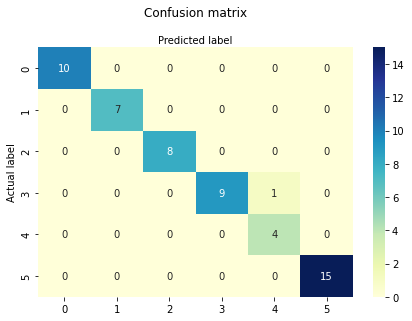

In [14]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Saving and loading model
---

In [15]:
import pickle   # pip install pickle-mixin

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [17]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test_2d, y_test)
print(result)



1.0


In [15]:
def preview_pred_video(input_video_path: str, output_video_path: str):
    cap = cv2.VideoCapture(input_video_path)
    out = cv2.VideoWriter(output_video_path, -1, 20.0, (640,480))
    # get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    suc, prev = cap.read()
    prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    out.write(prevgray-prevgray)

    for image in range(int(totalFrames) - 1):

        suc, img = cap.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
        
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        gray_smaller = cv2.resize(gray, (img_size,img_size)).flatten()
        
        gray_smaller = np.reshape(gray_smaller,(1,img_size*img_size))
        
        y_pred=knn.predict(gray_smaller)
        
        predict = str(y_pred)
        
        cv2.putText(gray, predict, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
        
        gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        
        out.write(gray_bgr)

        
    cap.release()
    out.release()
    
    
preview_pred_video('gmm_fingers.mp4','gmm_fingers_pred.mp4')
Video('gmm_fingers_pred.mp4')

## View on live
---

In [ ]:
# cap = cv2.VideoCapture(0)

cap = cv2.VideoCapture('http://192.168.0.169:4747/mjpegfeed?640x480')

# cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
# cap.set(CV_CAP_PROP_BUFFERSIZE, 3)

suc, prev = cap.read()
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)


while True:

    suc, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
    prevgray = gray
    
    gray_smaller = cv2.resize(gray, (img_size,img_size)).flatten()
        
    gray_smaller = np.reshape(gray_smaller,(1,img_size*img_size))
    
    y_pred=logreg.predict(gray_smaller)
    
    predict = str(y_pred)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    cv2.putText(gray, predict, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
    
    gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    cv2.imshow('flow', gray_bgr)
    

    key = cv2.waitKey(5)
    if key == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

## Keras model with image augmenting
---

### Pre process data
---

In [18]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_lables, test_size=0.15, random_state=42)

h_image = np.shape(X_train)[1]
w_image = np.shape(X_train)[2]

num_classes = 6

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

### Create Keras model
---

In [9]:
model_numbers = keras.Sequential([
    keras.layers.Flatten(input_shape=(h_image,w_image)),  # input layer (1)
    keras.layers.Dense(num_classes, activation='softmax') # output layer (2)  
])


model_numbers.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### Train model without image augemeting
---

In [20]:
model_numbers.fit(X_train, Y_train, epochs=3)


test_loss, test_acc = model_numbers.evaluate(X_test,  Y_test, verbose=1) 

print('Test accuracy:', test_acc)

predictions_of_test = model_numbers.predict(X_train)
predictions_of_test = np.argmax(predictions_of_test, axis=1)
predictions_of_train = model_numbers.predict(X_test)
predictions_of_train = np.argmax(predictions_of_train, axis=1)

Epoch 1/3
10/10 [==============================] - 1s 12ms/step - loss: 0.5931 - accuracy: 0.9601
Epoch 2/3
10/10 [==============================] - 0s 9ms/step - loss: 0.4636 - accuracy: 0.9867
Epoch 3/3
2/2 [==============================] - 0s 9ms/step - loss: 1.5643e-04 - accuracy: 1.0000
Test accuracy: 1.0


### Image augmenting
---


In [22]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode = 'constant',
        cval = 0,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        # shear_range=0.2,
        zoom_range= 0.2,
        rescale=1./255,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
X_train_4 = X_train.reshape(X_train.shape + (1,))

# train_generator = train_datagen.flow(X_train_4,Y_train,batch_size=batch_size,shuffle=True, save_to_dir='preview', save_prefix='num_test', save_format='jpeg')

train_generator = train_datagen.flow(X_train_4,Y_train,batch_size=batch_size,shuffle=True)


X_test_4 = X_test.reshape(X_test.shape + (1,))
# this is a similar generator, for validation data
# validation_generator = test_datagen.flow(X_test_4,Y_test,batch_size=batch_size,shuffle=True, save_to_dir='preview', save_prefix='num_train', save_format='jpeg')

validation_generator = test_datagen.flow(X_test_4,Y_test,batch_size=batch_size,shuffle=True)

### Generate images to preview
---

In [23]:
import shutil
import os
directory_path = 'Preview'
try:
    shutil.rmtree(directory_path)
except:
    pass
os.makedirs(directory_path, exist_ok=True)

In [24]:
i = 0
for batch in train_datagen.flow(X_train_4,Y_train, batch_size=1,
                          save_to_dir='preview', save_prefix='hands', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise it run endless

### Train model
---

In [50]:
model_numbers.fit(
        train_generator,
        steps_per_epoch=100 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model_numbers.save_weights('first_try.h5')  # always save your weights after training or during training

C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\ophir\AppData\Roaming\Python\Python39\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
6/6 [==============================] - 1s 154ms/step - loss: 2.0130 - accuracy: 0.2812 - val_loss: 0.9777 - val_accuracy: 0.9815
Epoch 2/50
6/6 [==============================] - 1s 81ms/step - loss: 1.9097 - accuracy: 0.2500
Epoch 3/50
6/6 [==============================] - 1s 104ms/step - loss: 2.2027 - accuracy: 0.1720
Epoch 4/50
6/6 [==============================] - 1s 97ms/step - loss: 2.0701 - accuracy: 0.1398
Epoch 5/50
6/6 [==============================] - 0s 75ms/step - loss: 1.9299 - accuracy: 0.2396
Epoch 6/50
6/6 [==============================] - 0s 77ms/step - loss: 2.1043 - accuracy: 0.2292
Epoch 7/50
6/6 [==============================] - 1s 88ms/step - loss: 2.0576 - accuracy: 0.2188
Epoch 8/50
6/6 [==============================] - 0s 76ms/step - loss: 2.1124 - accuracy: 0.2500
Epoch 9/50
6/6 [==============================] - 0s 77ms/step - loss: 1.9901 - accuracy: 0.2812
Epoch 10/50
6/6 [==============================] - 1s 83ms/step - loss: 2.0724 - ac

### Results preview
---

In [33]:
test_loss, test_acc = model_numbers.evaluate(X_test,  Y_test, verbose=1) 

print('Test accuracy:', test_acc)

predictions_of_test = model_numbers.predict(X_train)
predictions_of_test = np.argmax(predictions_of_test, axis=1)
predictions_of_train = model_numbers.predict(X_test)
predictions_of_train = np.argmax(predictions_of_train, axis=1)

2/2 [==============================] - 0s 7ms/step - loss: 2.5175e-04 - accuracy: 1.0000
Test accuracy: 1.0


In [40]:
model_numbers.save('keras_fingers_model')

INFO:tensorflow:Assets written to: keras_fingers_model\assets


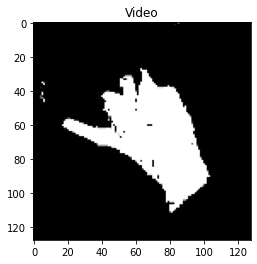

1

In [35]:
test = 9
img = cv2.normalize(X_test[test,:,:], None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)

show_img_in_notebook(img)
predictions_of_train[test]

Text(0.5, 257.44, 'Predicted label')

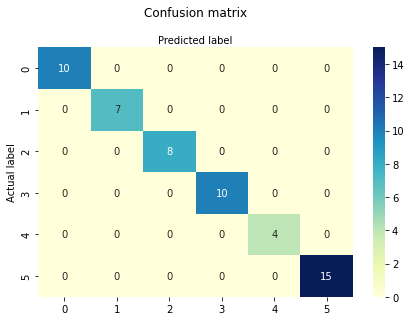

In [36]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, predictions_of_train)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')